# Homework 5

Implement a Kalman Filter to estimate the position and orientation of a vehicle from a GPS and an IMU. 
GPS provides global position information but can have accuracy issues due to signal obstructions and multipath errors.
IMU provides high-frequency acceleration and angular velocity measurements but suffers from drift over time. 
The idea is to fuse the data from these sensors and improve the accuracy and reliability of pose estimation for navigation applications.

The Data was collected from the NUANCE autonomous car and stored in a rosbag: https://drive.google.com/file/d/13NTbaSxY7uYbRrld7iVXB27czxcrRTL9/view?usp=drive_link 

We will use "/gps/fix" and "/imu/imu_uncompensated"

In [2]:
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt

b = bagreader('/home/meuli/src/eece7150/HW5/2023-10-19-14-14-38-filtered.bag')

# get the list of topics
print(b.topic_table)

data_gps = b.message_by_topic('/gps/fix')
data_imu = b.message_by_topic('/imu/imu_uncompensated')

d_gps = pd.read_csv(data_gps)
d_imu = pd.read_csv(data_imu)

[INFO]  Data folder /home/meuli/src/eece7150/HW5/2023-10-19-14-14-38-filtered already exists. Not creating.
                            Topics                             Types  \
0                         /gps/fix             sensor_msgs/NavSatFix   
1              /gps/time_reference         sensor_msgs/TimeReference   
2             /imu/imu_compensated                   sensor_msgs/Imu   
3           /imu/imu_uncompensated                   sensor_msgs/Imu   
4       /vehicle/brake_info_report      dbw_mkz_msgs/BrakeInfoReport   
5            /vehicle/brake_report          dbw_mkz_msgs/BrakeReport   
6             /vehicle/dbw_enabled                     std_msgs/Bool   
7       /vehicle/fuel_level_report      dbw_mkz_msgs/FuelLevelReport   
8             /vehicle/gear_report           dbw_mkz_msgs/GearReport   
9                 /vehicle/gps/fix             sensor_msgs/NavSatFix   
10               /vehicle/gps/time         sensor_msgs/TimeReference   
11                /vehicle/g

# Kalman Filter Implementation
Code up the Kalman Filter to compute pose estimates using Python.
Define and write up the equations for your process and measurement models, their covariances, and parameters in the Jupyter Notebook.
Define and report the initial conditions, as well. Develop functions for prediction and correction steps and estimate the state iteratively.

Implement a kalman filter to estimate 2D (x, y, theta) pose of the vehicle by fusing GPS and IMU measurements. Use constant-velocity model for IMU or include acceleration component.

Ignore computer accelerometer and gyroscope biases. Estimate them initially by averaging the readings at rest and subtracting them from your readings to unbias the measurements. Assume constant biases.

The process model, measurement model, and covariance update equations must be programmed independently. 

In [26]:
print(data_gps)

# Lat at 8, Lon at 9?

d_gps_lat = pd.read_csv(data_gps, index_col=7)
d_gps_lon = pd.read_csv(data_gps, index_col=8)



/home/meuli/src/eece7150/HW5/2023-10-19-14-14-38-filtered/gps-fix.csv


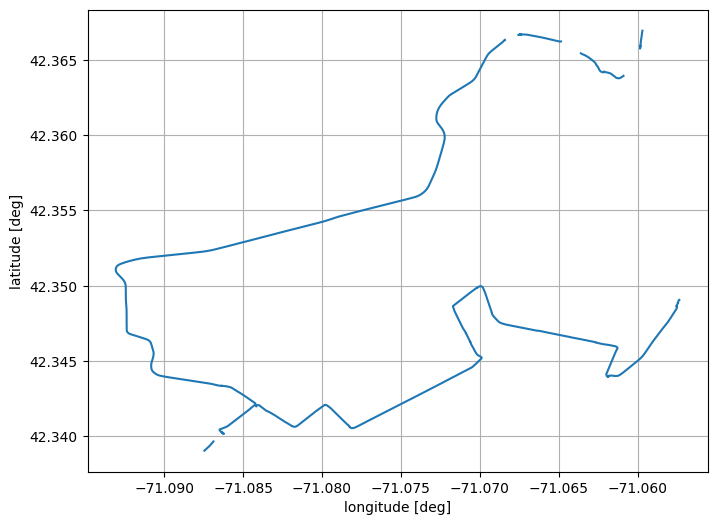

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(d_gps_lon.index[:], d_gps_lat.index[:])
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')
ax.grid()

Transform GPS trajectory from Longitude-Latitude to local X-Y so Kalman Filter can handle it

In [ ]:
origin = gt_trajectory_lla[:, 0]  # set the initial position to the origin
gt_trajectory_xyz = lla_to_enu(gt_trajectory_lla, origin)

In [49]:
imu_time = pd.read_csv(data_imu, index_col=0)

ang_vel_x = pd.read_csv(data_imu, index_col=18)
ang_vel_y = pd.read_csv(data_imu, index_col=19)
ang_vel_z = pd.read_csv(data_imu, index_col=20)

lin_accel_x = pd.read_csv(data_imu, index_col=30)
lin_accel_y = pd.read_csv(data_imu, index_col=31)
lin_accel_z = pd.read_csv(data_imu, index_col=32)

/tmp/ipykernel_183888/3003238058.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  imu_time = pd.read_csv(data_imu, index_col=0)
/tmp/ipykernel_183888/3003238058.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  ang_vel_x = pd.read_csv(data_imu, index_col=18)
/tmp/ipykernel_183888/3003238058.py:4: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  ang_vel_y = pd.read_csv(data_imu, index_col=19)
/tmp/ipykernel_183888/3003238058.py:5: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  ang_vel_z = pd.read_csv(data_imu, index_col=20)
/tmp/ipykernel_183888/3003238058.py:7: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  lin_accel_x = pd.read_csv(data_imu, index_col=30)
/tmp/ipykernel_183888/3003238058.py:8: DtypeWarnin

In [41]:
import numpy as np

-9.48012924194336
-0.8670625686645508


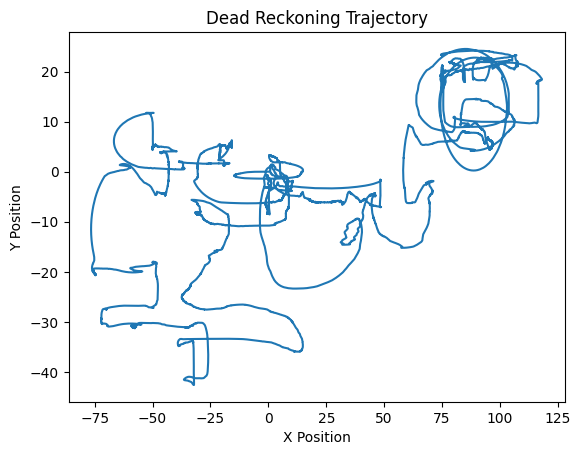

In [51]:
# Initialize variables
x_position = 0
y_position = 0

xs = []
ys = []

theta = 0  # Initial orientation

time0 = imu_time.index[0]

# Calculate the displacement in X and Y for each time step
for i in range(1, len(lin_accel_x)):
    dt = imu_time.index[i] - time0  # Assuming a sampling rate of 10 Hz
    time0 = imu_time.index[i]

    dx = lin_accel_x.index[i] * dt * np.cos(theta)
    dy = lin_accel_y.index[i] * dt * np.sin(theta)
    
    # Update the position
    x_position += dx
    y_position += dy
    xs.append(x_position)
    ys.append(y_position)

    # Update the orientation
    dtheta = ang_vel_z.index[i] * dt
    theta += dtheta

# Plot the dead reckoning trajectory
plt.plot(xs, ys)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Dead Reckoning Trajectory')
plt.show()

# Discussion and Analysis
Plot the raw GPS reading, Deadreckoned IMU estimates and the Kalman filtered state estimates of both the translational and rotational components. 

Reflect on the results and discuss the advantages and limitations of the Kalman filter fusion in improving position estimation.